# Tutorial 0d: A sample homework problem

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This tutorial was generated from a Jupyter notebook.  You can download the notebook [here](t0d_sample_homework_problem.ipynb).*

In [1]:
import numpy as np
import scipy.integrate
import scipy.optimize
import scipy.stats
import pandas as pd
import pymc3
import theano
import emcee

# Import pyplot for plotting
import matplotlib.pyplot as plt

# Import corner for plotting MCMC results
import corner

# BE/Bi 103 utilities
import bebi103

# Some pretty Seaborn settings
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

# Make Matplotlib plots appear inline
%matplotlib inline

# Import Bokeh modules for interactive plotting
import bokeh.io as bi
import bokeh.plotting as bp

# Set up Bokeh for inline viewing
bi.output_notebook()

Loading BokehJS ...

To give you an idea of what we would like in your homework responses, I show in this tutorial with an short homework problem.  The problem has both a theoretical part and a practical part to demonstrate how we would like each done.  (Note, we will not have many theoretical problems in the class, but I just wanted to show an example here for the few we will have.)  It is important to show and discuss all reasoning and code that goes into the solution.

A quick note: Don't freak out that you don't understand everything in this problem.  You will by the end of the course.  This is just to show what kinds of solutions we expect on the homework.

### Example problem 0.1 (Heritability and finch beaks)

Peter and Rosemary Grant have been working on the Galápagos island of Daphne for over forty years.  During this time, they have collected lots and lots of data about physiological features of finches.  Last year, they published a book with a summary of some of their major results (Grant P. R., Grant B. R., *Data from: 40 years of evolution. Darwin's finches on Daphne Major Island*, Princeton University Press, 2014). They made their data from the book publicly available via the [Dryad Digital Repository](http://dx.doi.org/10.5061/dryad.g6g3h).

We will investigate their data on the heritability of beak depth (the distance, top to bottom, of a closed beak) in the ground finch *Geospiza fortis*.  The data set consists of the maternal beak depth, the paternal beak depth, and the mean beak depth of their offspring.  You can download the data set, which I got from Dryad and tidied up into a CSV file, [here](../data/grant_and_grant.csv).

**a)** The **narrow sense heritability**, denoted $h^2$, of a trait is defined as the ratio of the additive genetic variance in offspring to the total phenotypic variance in the parent.  The additive genetic variance of a population describes the variability in a trait resulting from the sum of all effects of the alleles.  In other words, $h^2$ is the ratio of the parent-offspring covariance in the trait value to the variance in the parents.

\begin{align}
h^2 = \frac{\sigma_{po}^2}{\sigma_p^2},
\end{align}

where the subscripts $o$ and $p$ indicate offspring and parents, respectively.

In practice, $h^2$ is computed by plotting the average beak depth of the offspring against the average beak depth of the two parents, and then preforming a linear regression, with $h^2$ being given by the slope.  Show that this gives $h^2$ as we have defined it.

*Note*: in this analysis, we are neglecting confounding issues and just assuming the environment is unchanging and that the mean trait values we are using for the parents and the offspring is indicative of the differences.

**b)** Plot the mean parental beak depth versus the mean offspring beak depth, including a linear regression.  Report the regression parameters with error bars.

### Example problem 0.1 solution

**a)** We are first asked to prove that $h^2$ is the slope of a linear regression line between of the plot of parental beak depth versus offspring beak depth.  We are actually seeking to prove something more general: the slope of a linear regression between two variables, say $x$ and $y$, is the ratio of the covariance to the variance in the $x$-variable.  To prove, this we set up the linear regression, as in class, by writing the posterior probability distribution.  Beginning with Bayes's theorem, 

\begin{align}
P(m, b, \sigma \mid D) = \frac{P(D\mid m, b, \sigma)\,P(m, b, \sigma)}{P(D)}.
\end{align}

We assume the data follow $y = mx + b$ and that the errors are Gaussian distributed, all with the same error bar, $\sigma$.  This gives a likelihood of

\begin{align}
P(D\mid m, b, \sigma) = \prod_{i\in D} \frac{1}{\sqrt{2\pi\sigma^2}}\,
\exp\left\{-\frac{(y_i - m x_i - b)^2}{2\sigma^2}\right\}.
\end{align}

We assume a Jeffreys prior for $\sigma$, and an uninformative prior for the linear regression parameters $m$ and $b$ as discussed in class.

\begin{align}
P(m, b, \sigma) \propto \frac{1}{\sigma(1 + m^2)^{\frac{3}{2}}}.
\end{align}

The log posterior is then

\begin{align}
\ln P(m, b, \sigma \mid D) \propto -(n + 1) \ln \sigma - \frac{3}{2}\,\ln\left(1 + m^2\right) - \frac{1}{2\sigma^2}\sum_{i\in D} \left(y_i - m x_i - b\right)^2,
\end{align}

where $n = |D|$.

To find the most probable slope and intercept, we differentiate the log posterior and find where the gradient is zero.

\begin{align}
\frac{\partial}{\partial m}\,\ln P(m, b, \sigma \mid D) 
&= -\frac{3m}{1+m^2} + 2\sum_{i\in D} \left( y_i - m x_i - b\right)x_i = 0, \\[1em]
\frac{\partial}{\partial b}\,\ln P(m, b, \sigma \mid D)
&= 2\sum_{i\in D} \left( y_i - m x_i - b\right) = 0.
\end{align}

We can multiply the each equation by $1/2n$ to get

\begin{align}
-\frac{3m}{2n\left(1+m^2\right)} + \langle xy \rangle - m\langle x^2 \rangle - b\langle x \rangle &= 0,\\[1em]
\frac{1}{n}\sum_{i\in D} \left( y_i - m x_i - b\right) = \langle y\rangle - m\langle x\rangle - b &= 0.
\end{align}

We solve the bottom equation for $b$

\begin{align}
b = \langle y \rangle - m \langle x \rangle,
\end{align}

which we then insert into the top equation, giving

\begin{align}
-\frac{3m}{2n\left(1+m^2\right)} + \langle xy \rangle - m\langle x^2 \rangle - \left(\langle y \rangle - m \langle x\right\rangle)\langle x \rangle &= 0.
\end{align}

This can be rearranged to give

\begin{align}
m = \frac{\langle xy \rangle - \langle x \rangle\langle y\rangle}{\left\langle x^2 - \langle x \rangle^2\right\rangle} -\frac{3m}{2n\left(1+m^2\right)\left\langle x^2 - \langle x\rangle^2\right\rangle}.
\end{align}

This is a cubic equation in $m$, for which an analytical solution exists, but is messy.  Instead, we make the approximation that if $n$ is large and the covariance is not too small, the second term is negligible, which is equivalent to assuming the prior for $m$ is uniform, giving

\begin{align}
m \approx \frac{\langle xy\rangle - \langle x\rangle \langle y \rangle}{\left\langle x^2 - \langle x \rangle^2\right\rangle}.
\end{align}

We recognize the numerator as the sample covariance between $x$ and $y$ and the denominator as the sample variance of $x$.  Thus, we have proven what we set out to prove.

Interestingly, we found that if we want to compute $h^2$ by linear regression, we should assume a uniform prior on the slope.

**b)** We start by loading in the data set and adjusting column headings for convenience.

In [3]:
# Read data
df = pd.read_csv('data/grant_and_grant_2014.csv')

# Rename columns
df.columns = ('offspring_bd', 'male_bd', 'female_bd')

We will need the mean parental beak depth for our regression, so we create a new column in the `DataFrame` that has that.

In [4]:
# Make a new column with the mean of the male and female parent columns
df['parent_bd'] = (df.male_bd + df.female_bd) / 2

We'll first plot the data to see what we are dealing with.  We make the plot interactive with Bokeh to enable zooming. (*Note*: In your homeworks, you can use Matplotlib; I'm just using Bokeh here for show, and because I like it.)

In [5]:
p = bp.figure(width=500, height=400, x_axis_label='parental beak depth(mm)',
              y_axis_label='offspring beak depth (mm)', 
              tools='pan,wheel_zoom,box_zoom,resize,reset')

p.circle(df['parent_bd'], df['offspring_bd'])
bi.show(p)

By eye, we see correlation between the parents and the offspring.  To find the most probable parameter values for the slope and intercept, we can be cute and use the result derived above and just compute the sample covariance matrix.

In [6]:
# Compute covariance matrix
cov = df.cov()

# Compute the regression line
h_2 = cov['parent_bd']['offspring_bd'] / cov['parent_bd']['parent_bd']
intercept = df.offspring_bd.mean() - h_2 * df.parent_bd.mean()

# Print the results to the screen
print("""
heritability = {0:.2f}
   intercept = {1:.2f} mm
""".format(h_2, intercept))


heritability = 0.72
   intercept = 2.45 mm



To get error bars and to do a more complete analysis, we will sample the posterior distribution using Markov chain Monte Carlo.  We will use the `emcee` package, so we only need to define a function for the unnormalized log of the posterior. (The prior and likelihood are both normalized.) It is the product of Gaussians of data points with a Jeffreys prior.

In [7]:
def log_prior(p, pmin, pmax):
    """
    Log of prior for linear regression with unknown constant
    error bars on measurments.
    
    Parameters
    ----------
    p : array_like, shape (3,)
        Array of parameters `slope`, `intercept`, and `sigma`
    pmin : array_like, shape (3,)
        Array of minimum values for parameters `slope`, 
        `intercept`, and `sigma`
    pmax : array_like, shape (3,)
        Array of maximum values for parameters `slope`, 
        `intercept`, and `sigma`
    
    Returns
    -------
    output : float
        Log of prior probability with uniform priors on slope and
        intercept and Jeffreys prior on `sigma`.
    """
    
    if np.any(p < pmin) or np.any(p > pmax):
        return -np.inf

    return -np.sum(np.log(pmax[:2] - pmin[:2])) \
           - np.log(p[-1] * np.log(pmax[-1] / pmin[-1]))

    
def log_likelihood(p, x, y):
    """
    Log of likelihood for linear regression with unknown constant
    error bars on measurments.
    
    Parameters
    ----------
    p : array_like, shape (3,)
        Array of parameters `slope`, `intercept`, and `sigma`
    x : array_like
        Array of x-values
    y : array_like
        Array of y-values

    Returns
    -------
    output : float
        Log of Gaussian likelihood.
    """
    # Unpack parameters
    slope, intercept, sigma = p
    
    return -len(x) * np.log(sigma) \
            - np.sum((y - slope * x - intercept)**2) / 2.0 / sigma**2   

    
def log_posterior(p, pmin, pmax, x, y):
    """
    Log of posterior for linear regression with unknown constant
    error bars on measurments.
    
    Parameters
    ----------
    p : array_like, shape (3,)
        Array of parameters `slope`, `intercept`, and `sigma`
    pmin : array_like, shape (3,)
        Array of minimum values for parameters `slope`, 
        `intercept`, and `sigma`
    pmax : array_like, shape (3,)
        Array of maximum values for parameters `slope`, 
        `intercept`, and `sigma`
    x : array_like
        Array of x-values
    y : array_like
        Array of y-values
    
    Returns
    -------
    output : float
        Log of posterior probability with Jeffreys prior on `sigma`.
    """
    lp = log_prior(p, pmin, pmax)
    
    if lp == -np.inf:
        return lp
    
    return lp + log_likelihood(p, x, y)

Now we set the maximum and minimum values for the parameters.

In [8]:
# Min and max slope, intercept, sigma
pmin = np.array([-100, -100, 1e-6])
pmax = np.array([100, 100, 1e6])

Now that we have defined these functions, we can proceed to set up the parameters for the MCMC calculation.

In [9]:
# Specify paremeters for emcee
n_dim = 3        # number of parameters in the model
n_walkers = 10   # number of MCMC walkers
n_burn = 1000    # "burn-in" period to let chains stabilize
n_steps = 5000   # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
# p0[i,j] is the starting point for walk i along variable j.
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(-1.0, 1.0, n_walkers)     # slope
p0[:,1] = np.random.uniform(-10.0, 10.0, n_walkers)   # intercept
p0[:,2] = np.random.exponential(1.0, n_walkers)       # sigma

We can now run the sampler!

In [10]:
# Arguments passed to log posterior
args = (pmin, pmax, df.parent_bd.values, df.offspring_bd.values)

# Set up the EnsembleSampler instance
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior, args=args)

# Do burn-in
pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)

# Sample again, starting from end burn-in state
_ = sampler.run_mcmc(pos, n_steps)

Now that we have the MCMC traces, we can compute the mode/HPD.  We'll use the `hpd()` function given in class.

In [11]:
# Compute HPD credible regions
herit_hpd = bebi103.hpd(sampler.flatchain[:,0], 0.95)
herit_mode = sampler.flatchain[:,0][np.argmax(sampler.flatlnprobability)]
intercept_mode = sampler.flatchain[:,1][np.argmax(sampler.flatlnprobability)]

# Print the results
print("""
heritability 95% HPD with mode
------------------------------
{:.2f}    {:.2f}     {:.2f}
""".format(herit_hpd[0], herit_mode,  herit_hpd[1]))


heritability 95% HPD with mode
------------------------------
0.66    0.72     0.79



The mode is, as expected, the same result we got with our calculation based on the covariance of the data.  We can use our sample trace to compute the 95% credible region on the linear regression line.

In [12]:
# Extract slopes and intercepts
slope, intercept = sampler.flatchain[:,0], sampler.flatchain[:,1]

# Get sorted data
x = np.sort(df.parent_bd.values)

# Get array of possible values of regression line
reg_vals = np.outer(slope, x) + np.outer(intercept, np.ones_like(x))

# Compute upper and lower bound for 95% credible region for each datum
lower, upper = np.percentile(reg_vals, (2.5, 97.5), axis=0)
    
# Make a line of the most probably regression line for plotting
x_most_prob = np.array([x.min(), x.max()])
y_most_prob = herit_mode * x_most_prob + intercept_mode

# Build plot
p = bp.figure(width=500, height=400, x_axis_label='parental beak depth(mm)',
              y_axis_label='offspring beak depth (mm)', 
              tools='pan,wheel_zoom,box_zoom,resize,reset')

p.patch(np.concatenate((x, x[::-1])), np.concatenate((upper, lower[::-1])),
        color='lightgray')
p.line(x_most_prob, y_most_prob, line_width=4, color='gray')
p.circle(df['parent_bd'], df['offspring_bd'])
bi.show(p)

And that should do it for the homework solution.  Notice that all logic was clearly presented, all code was explained, and the graphics were clearly presented.  I chose to use Bokeh for interactive graphics because there were enough data points that it is worth zooming in and out.

For your edification, I provide some auxiliary material for this problem.  This would be welcomed in a homework submission, but is not necessary.

### MCMC using PyMC3

For fun, let's repeat our MCMC analysis using PyMC3 and its fast no U-turn (NUTS) sampler.  This sampler works well for very large problems (ours is small, only three parameters).

PyMC3 is flexible in that you can rapidly define your models with built-in functions, especially if you are using standard probability distributions.  It is fast because it uses [Theano](http://www.deeplearning.net/software/theano/) to do the sampling using compiled code.  The use of Theano does make PyMC3 a little bit more difficult to use than `emcee`, since you are restricted to Theano's built-in operators (though there are some ways around that).

Anyhow, the code below does MCMC sampling of the posterior for the linear regression using PyMC3.

In [13]:
# Make custom Jeffreys prior, returns log prior
def jeffreys(value):
    return -theano.tensor.log(value)

# Instantial model
basic_model = pymc3.Model()
with basic_model:
    # Priors for unknown model parameters
    sigma = pymc3.DensityDist('sigma', jeffreys, testval=1)
    slope = pymc3.Uniform('slope', lower=-1, upper=1, testval=0.5)
    intercept = pymc3.Uniform('intercept', lower=-10, upper=10, testval=0)

    # Expected value of outcome
    mu = slope * df.parent_bd + intercept

    # Likelihood (sampling distribution) of observations
    y_obs = pymc3.Normal('y_obs', mu=mu, sd=sigma, observed=df.offspring_bd)
    
    # obtain starting values via MAP
    start = pymc3.find_MAP(fmin=scipy.optimize.fmin_powell)

    # instantiate sampler
    step = pymc3.NUTS()

    # draw 1000 posterior samples for burn-in
    trace = pymc3.sample(1000, step, progressbar=False, njobs=None)

    # Start next run of 5000 samples at the last sampled position.
    step = pymc3.NUTS(scaling=trace[-1])
    trace = pymc3.sample(5000, step, start=trace[-1], njobs=None)

 [-----------------100%-----------------] 5000 of 5000 complete in 17.9 sec

We can use the `pymc3.summary` function to print out the results.

In [14]:
# Print summary of MCMC results
pymc3.summary(trace, ['slope', 'intercept', 'sigma'])


slope:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.724            0.034            0.001            [0.657, 0.790]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.659          0.702          0.723          0.746          0.793


intercept:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  2.435            0.322            0.007            [1.790, 3.050]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  1.791          2.230          2.443          2.649          3.052


sigma:

  Mean             SD               MC Error         95% HPD interval
  ---------------------

/Users/Justin/anaconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


We see that our mean heredity is 0.72, with an HPD that is the same as we got with `emcee`.

### Plotting the 2D distribution of beak depths

We may also think of the experimental data as being sampled out of a two-dimensional distribution.  If we approximate this distribution as Gaussian, we can make a plot of the distribution with the sample points.  This is a nice way of looking at the data and visualizing the heredity (indicated by the covariance of the 2D Gaussian).

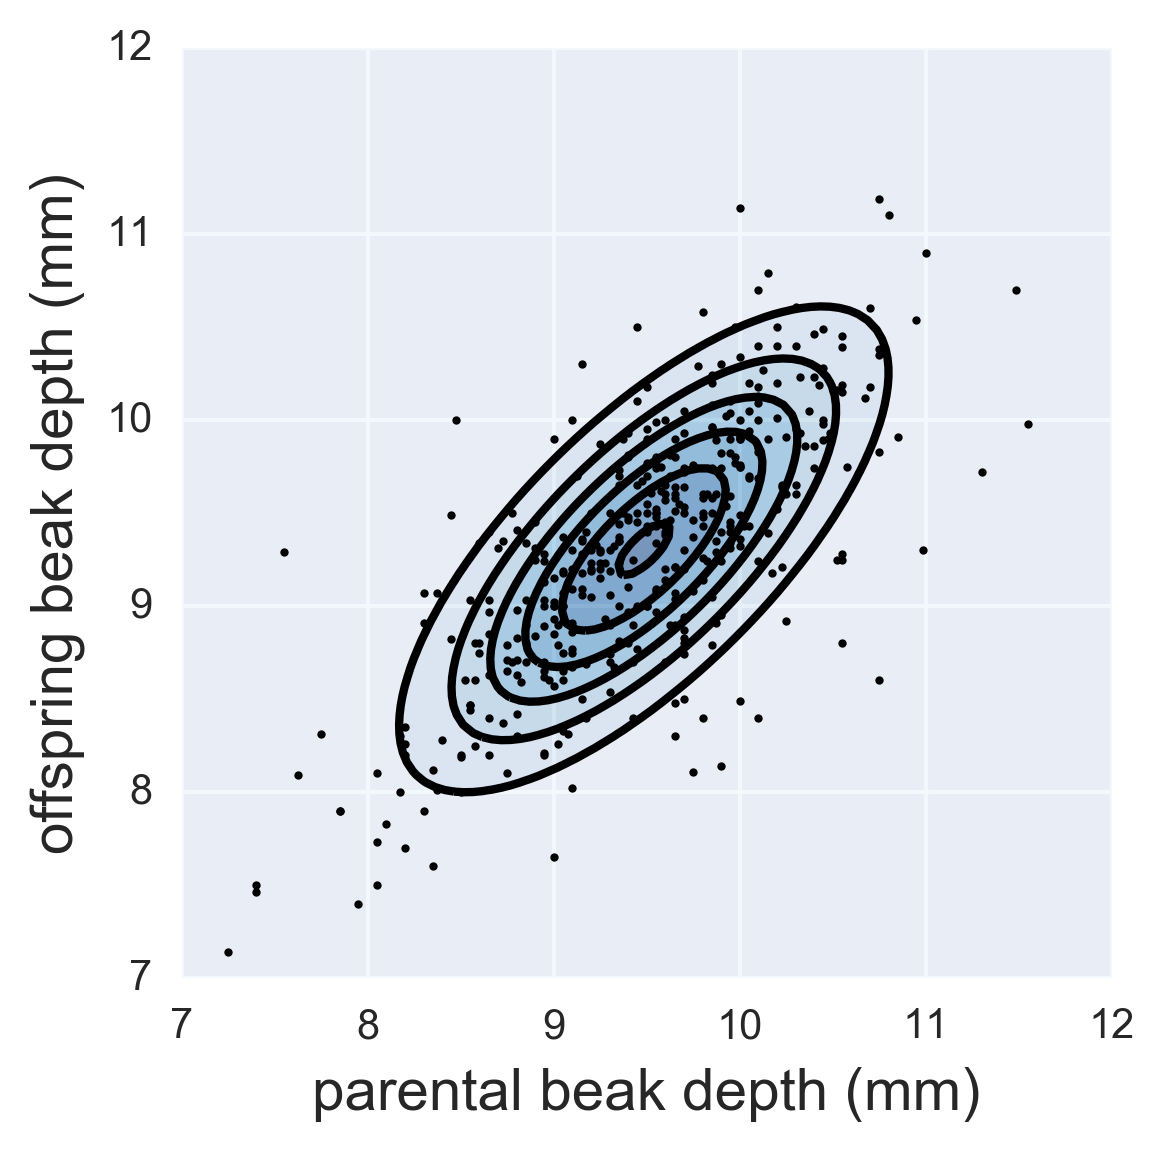

In [15]:
# Set up array of mu's and covariance matrix (already calc'd)
mu = np.array([df.parent_bd.mean(), df.offspring_bd.mean()])
cov_mat = np.array(
    [[cov.parent_bd['parent_bd'], cov.parent_bd['offspring_bd']],
     [cov.parent_bd['offspring_bd'], cov.offspring_bd['offspring_bd']]])

# Set up sampling for plotting
x = np.linspace(7, 12, 100)
y = np.linspace(7, 12, 100)
xx, yy = np.meshgrid(x, y)
pos = np.empty(xx.shape + (2,))
pos[:, :, 0] = xx 
pos[:, :, 1] = yy

# Instantiate multivariate normal instance to get the PDF for plotting
rv = scipy.stats.multivariate_normal(mu, cov_mat)

# Generate the plot
plt.contourf(x, y, rv.pdf(pos), cmap=plt.cm.Blues, alpha=0.5)
plt.contour(x, y, rv.pdf(pos), colors='k')
plt.plot(df.parent_bd, df.offspring_bd, 'k.', markersize=4)
plt.xlabel('parental beak depth (mm)')
plt.ylabel('offspring beak depth (mm)')

# Set the aspect ratio to be one-to-one for apples-to-apples comparison
plt.axes().set_aspect('equal')

### Alternate approach
In light of the above plot, we may wish to take a different approach.  Suppose instead that we assume the offspring and parental beak depth are drawn from a two-dimensional Gaussian distribution, and we wish to estimate the parameters of this distribution.   The parameters are the mean and standard deviation parental beak width, $\mu_p$ and $\sigma_p$, the mean and standard deviation offspring beak width, $\mu_o$ and $\sigma_o$, and the square root of the covariance between the two, $\sigma_{po}$.  Couched in term of Bayes's theorem, we wish to compute the posterior distribution

\begin{align}
P(\mu_p, \mu_o, \sigma_p, \sigma_o, \sigma_{po} \mid D) = \frac{P(D \mid \mu_p, \mu_o, \sigma_p, \sigma_o, \sigma_{po})\,P(\mu_p, \mu_o, \sigma_p, \sigma_o, \sigma_{po})}{P(D)}.
\end{align}

We take our likelihood to be a bivariate Gaussian of independent measurements.

\begin{align}
P(D \mid \mu_p, \mu_o, \sigma_p, \sigma_o, \sigma_{po}) = 
\prod_{i\in D} \frac{1}{2\pi \det (\sigma^2)}
\exp\left\{-\frac{1}{2}\,\mathbf{x}^\mathsf{T}\cdot \sigma^{-2} \cdot \mathbf{x}\right\},
\end{align}

where 

\begin{align}
\mathbf{x} &= \begin{pmatrix}
p_i - \mu_p \\
o_i - \mu_o
\end{pmatrix}, \\[1em]
\text{and } \sigma^2 &= \begin{pmatrix}
\sigma_p^2 & \sigma_{po} \\
\sigma_{po} & \sigma_o^2
\end{pmatrix}.
\end{align}

Here, $p_i$ and $o_i$ are respectively the parental and offspring beak depth for sample $i$.  For the prior, we assume Jeffreys priors on all standard deviations and uniform priors on $\mu_o$ and $\mu_p$.  We can code this posterior up to use with `emcee`.

For the purposes of coding up the bivariate Gaussian, it is useful to write the log likelihood by explicitly inverting the covariance matrix and evaluating the sum of quadratic forms in the exponential.

\begin{align}
&\ln P(D \mid \mu_p, \mu_o, \sigma_p, \sigma_o, \sigma_{po}) = \text{constant} 
- n\ln \left(\sigma_p^2 \sigma_o^2 - \sigma_{po}^2\right) \\
&\;\;\;\;-\frac{n}{2(\sigma_p^2 \sigma_o^2 - \sigma_{po}^2)}\left[\left\langle (p - \mu_p)^2\right \rangle\sigma_o^2
+ \left\langle (o - \mu_o)^2\right \rangle\sigma_p^2
- 2 \left\langle (o - \mu_o)(p - \mu_p)\right \rangle \sigma_{po}\right].
\end{align}

In [16]:
def log_posterior_bigauss(p, parent_bd, offspring_bd):
    """
    Log posterior for model of beak width with a bivariate Gaussian.
    """
    
    # Disallow negative parameter values (all are impossible)
    if np.any(p <= 0):
        return -np.inf
    
    # Unpack parameters
    mu_p, mu_o, sigma_p, sigma_o, sigma_po = p

    # Compute determinant of covariance matrix
    det = (sigma_p * sigma_o)**2 - sigma_po**4
    
    # Matrix must be positive definite
    if det <= 0:
        return -np.inf
    
    # Compute means
    p_var = ((parent_bd - mu_p)**2).mean()
    o_var = ((offspring_bd - mu_o)**2).mean()
    covar = ((parent_bd - mu_p) * (offspring_bd - mu_o)).mean()
    
    # Number of data points
    n = len(parent_bd)
    
    # Compute log prior
    log_prior = -np.log(sigma_p * sigma_o * sigma_po)

    # Return log likelihood
    log_like = -n * np.log(det) - n / 2 / det * (p_var * sigma_o**2 
                                                 + o_var * sigma_p**2 
                                                 - 2 * covar * sigma_po**2)
    
    return log_like + log_prior

With the log posterior in hand, we can set up our MCMC calculation.

In [17]:
# Specify paremeters for emcee
n_dim = 5          # number of parameters in the model
n_walkers = 10     # number of MCMC walkers
n_burn = 5000     # "burn-in" period to let chains stabilize
n_steps = 5000    # number of MCMC steps to take after burn-in

# Seed random number generator for reproducibility
np.random.seed(42)

# Generate random starting points for walkers.  
p0 = np.empty((n_walkers, n_dim))
p0[:,0] = np.random.uniform(9, 10, n_walkers)         # mu_p
p0[:,1] = np.random.uniform(9, 10, n_walkers)         # mu_o
p0[:,2] = np.random.uniform(0.3, 0.5, n_walkers)      # sigma_p
p0[:,3] = np.random.uniform(0.3, 0.5, n_walkers)      # sigma_o
p0[:,4] = np.random.uniform(0.3, 0.5, n_walkers)      # sigma_op

# Set up the EnsembleSampler instance
sampler_bigauss = emcee.EnsembleSampler(n_walkers, n_dim, log_posterior_bigauss, 
                                        args=(df.parent_bd, df.offspring_bd))

# Do burn-in
pos, prob, state = sampler_bigauss.run_mcmc(p0, n_burn, storechain=False)

# Sample again, starting from end burn-in state
_ = sampler_bigauss.run_mcmc(pos, n_steps)

We can extract the most probable values and 95% HPDs from the trace.

In [18]:
# Get index of parameter values with highest posterior probability
ind = np.argmax(sampler_bigauss.flatlnprobability)

# Get modes and hpds
modes = tuple([sampler_bigauss.flatchain[ind, i] for i in range(5)])
hpds = np.array([bebi103.hpd(sampler_bigauss.flatchain[:,i], 0.95) 
                 for i in range(5)])

fmt = tuple(hpds[:,0]) + modes + tuple(hpds[:,1])
print("""
95% HPDs with modes (all units mm)
----------------------------------
µ_p  : [{0:.2f}   {5:.2f}   {10:.2f}]
µ_o  : [{1:.2f}   {6:.2f}   {11:.2f}]
σ_p  : [{2:.2f}   {7:.2f}   {12:.2f}]
σ_o  : [{3:.2f}   {8:.2f}   {13:.2f}]
σ_op : [{4:.2f}   {9:.2f}   {14:.2f}]
""".format(*fmt))


95% HPDs with modes (all units mm)
----------------------------------
µ_p  : [9.44   9.48   9.53]
µ_o  : [9.26   9.31   9.35]
σ_p  : [0.46   0.49   0.51]
σ_o  : [0.46   0.48   0.51]
σ_op : [0.39   0.41   0.44]



We are really after $P(h^2\mid D)$.  We can easily compute this from the posterior sample.  First, we'll compute the mode and HPD.  For comparison to a Gaussian distribution later, we will also compute the mean and standard deviation of the distribution.

In [19]:
# Construct samples of heritability from sample of covariance matrix
herit_samples = sampler_bigauss.flatchain[:,4]**2 \
                    / sampler_bigauss.flatchain[:,2]**2

# Compute the mode and HPD
mode = herit_samples[np.argmax(sampler_bigauss.flatlnprobability)]
herit_hpd = bebi103.hpd(herit_samples, 0.95)

# Print the mode and HPD to the screen
print("""
Heritability mode and 95% HPD
-----------------------------
{0:.2f}    {1:.2f}    {2:.2f}
""".format(herit_hpd[0], mode, herit_hpd[1]))

# Compute the mean and standard deviation
herit_mean = herit_samples.mean()
herit_std = herit_samples.std()

# Print to the screen
print("""
Heritability mean and standard deviation
----------------------------------------
{0:.2f} ± {1:.2f}
""".format(herit_mean, herit_std))


Heritability mode and 95% HPD
-----------------------------
0.67    0.72    0.77


Heritability mean and standard deviation
----------------------------------------
0.72 ± 0.02



To plot the distribution $P(h^2\mid D)$, we will perform kernel density estimation with automatic bandwidth selection to avoid binning effects.  We also plot the Gaussian distribution with the same mean and variance for comparison.

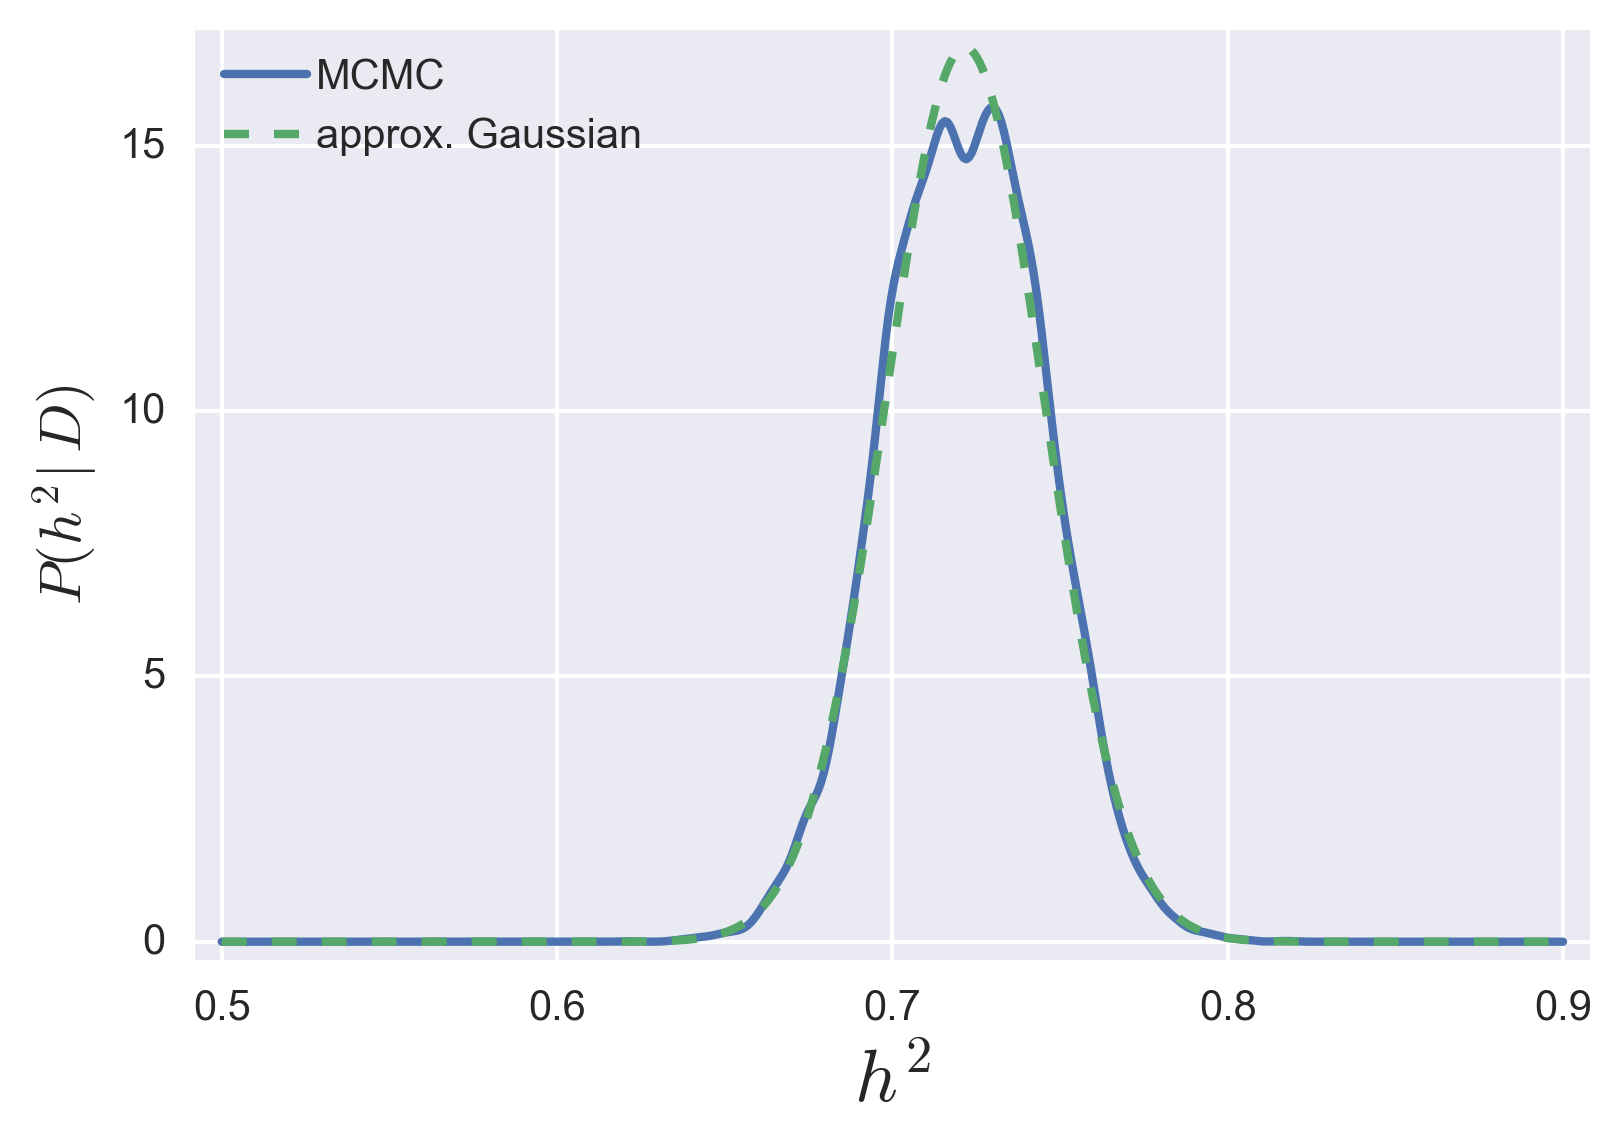

In [20]:
# Compute kernel
kde = scipy.stats.gaussian_kde(herit_samples, bw_method='scott')

# Evaluate kernel
h2 = np.linspace(0.5, 0.9, 500)
p = kde.evaluate(h2)

# Compute Gaussian
rv = scipy.stats.norm(herit_mean, herit_std)
p_gauss = rv.pdf(h2)

# Plot distributions
plt.plot(h2, p)
plt.plot(h2, p_gauss, '--')
plt.margins(0.02)
plt.xlabel('$h^2$', fontsize=18)
plt.ylabel('$P(h^2 \!\mid D)$')
plt.legend(('MCMC', 'approx. Gaussian'), loc='upper left')

The distribution is approximately Gaussian, just a little sharper.  

Note that while the most probable $h^2$ is the same we achieved via linear regression, the 95% HPD region is tighter.  These are two different means of estimating the parameters.  The models are fundamentally different.  In the linear regression, we assume that the parental beak depths are measured without error and that the error in the measured beak depth of the offspring is Gaussian distributed *with the true values of the beak depths falling exactly on a line*.  We proved analytically that finding the most probable heritability is the same as performing a regression to get the slope of a line.  But the posterior distribution we are calculating there is not really what we want because this model is kind of absurd.  There is no reason to expect that the beak depths would be exactly linearly related to the parents.

In the present model, we just assume that we are taking samples of beak depths that are Gaussian distributed and possibly correlated.  We make no distinction between measurement errors and the variability throughout the population.  If the variability throughout the population is much bigger than the measurement errors, the measurement error can be neglected.  This is much more satisfying to me; it makes no pretense that the points should lie along a line.